In [46]:
# Importing the libraries
import os
import re, string
import numpy as np
import pandas as pd
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud, STOPWORDS
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator,TransformerMixin
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shind\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shind\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [47]:
# Loading the training data
train_df = pd.read_csv("D:/Projects/toxic-comment-classification\data/raw-data/train.csv")
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [14]:
# Checking the total number of rows and column in our dataset
train_df.shape

(159571, 8)

In [15]:
# Loading the test data
test_df = pd.read_csv("D:/Projects/toxic-comment-classification\data/raw-data/test.csv")
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [16]:
# Checking for missing data
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [21]:
# Calculating the number of samples for each toxicity level class
target_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
total_samples = {}
for label in target_labels:
    total_samples[label] = train_df[train_df[label] == 1].shape[0]
total_samples

{'toxic': 15294,
 'severe_toxic': 1595,
 'obscene': 8449,
 'threat': 478,
 'insult': 7877,
 'identity_hate': 1405}

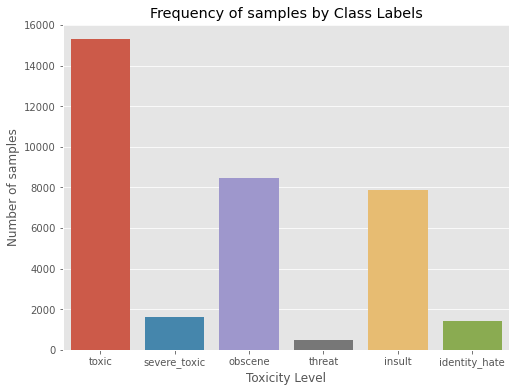

In [34]:
# Plotting a barplot to visualize the class samples frequency
plt.figure(figsize=(8, 6))
sns.barplot(x=list(total_samples.keys()), y=list(total_samples.values()))
plt.xlabel("Toxicity Level")
plt.ylabel("Number of samples")
plt.title("Frequency of samples by Class Labels")
plt.show()

In [36]:
# Creating a function to clean the training dataset
def clean_text(text):
    """This function will take text as input and return a cleaned text 
        by removing html char, punctuations, non-letters, newline and converting it 
        to lower case.

    Parameters
    ----------
    text : String
        Input raw text data string 

    Returns
    -------
    String
        Cleaned version of input text data
    """
    # Replacing the HTMl characters with " "
    text = re.sub("<.*?>", " ", text)
    # Removing the punctuations
    text = text.translate(str.maketrans(" ", " ", string.punctuation))
    # Removing non-letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # Replacing newline with space
    text = re.sub("\n", " ", text)
    # Converting to lower case letters
    text = text.lower()
    # Split on space and rejoin to remove extra spaces
    text = " ".join(text.split())
    
    return text

In [42]:
# Creating a function to remove english stopwords


def remove_stopwords(text):
    """This function will remove stopwords from a given text of data.

    Parameters
    ----------
    text : String
        Input raw text data string
    stop_words :  List
        List containing English stopwords

    Returns
    -------
    String
        Text without any stopwords
    """
    
    # Creating a list of english stopwords
    stop_words = stopwords.words("english")
    # Tokenize the sentences to words
    text = word_tokenize(text)
    # Removing the stop words
    text = [word for word in text if not word in stop_words]
    # Joining the cleaned list
    text = " ".join(text)
    
    return text

In [49]:
# Applying the above functions on our train text data
train_df["comment_text"] = train_df["comment_text"].swifter.apply(clean_text)
train_df["comment_text"] = train_df["comment_text"].swifter.apply(remove_stopwords)
train_df.head()

Pandas Apply: 100%|██████████| 159571/159571 [04:00<00:00, 663.05it/s] 


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww matches background colour im seemingly st...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really trying edit war guy constant...,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real suggestions improvement wondere...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page thats,0,0,0,0,0,0
